In [172]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
from h2o.transforms.decomposition import H2OPCA
h2o.init(max_mem_size="24G")


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpkb6o8arf
  JVM stdout: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpkb6o8arf/h2o_chandlervaughn_started_from_python.out
  JVM stderr: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpkb6o8arf/h2o_chandlervaughn_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,"7 days, 14 hours and 14 minutes"
H2O_cluster_name:,H2O_from_python_chandlervaughn_p1zine
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,24 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [173]:
#dataset = h2o.import_file('https://song-feature-csvs.s3.amazonaws.com/final_dataset.csv')

ext_drive_dir = '/volumes/CCV_SSD_1/'
dataset = h2o.import_file(ext_drive_dir+'final_dataset_new.csv')
dataset.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [248]:
# Identify predictors and response
x = dataset.columns
y = "genre"
x.remove(y)

#dataset[y].unique()
dataset[y] = dataset[y].asfactor()

In [311]:
#impute any na's to zero
dataset[x].impute(column = 0, values = [0 for c in range(dataset[x].ncol)])
dataset[x].isna().any()

False

In [312]:
#subset the data so that we can work with it
#eventually we need to do all data for modeling
#using splitframe so we get random rows
subset_dataset_train, subset_dataset_test, therest = dataset.split_frame(ratios=[0.01, 0.01])

In [313]:
print("Rows To Process: " + str(subset_dataset_train.nrows))
print("Dataframe Shape: " + str(subset_dataset_train.shape))

Rows To Process: 583
Dataframe Shape: (583, 8090)


In [314]:
#subset the data so that we can work with it
#eventually we need to do all data for modeling
#subset_dataset = dataset[range(0,2000,1),:]
subset_dataset_train[y] = subset_dataset_train[y].asfactor()
subset_dataset_train[x] = subset_dataset_train[x].asnumeric() 
subset_dataset_test[y] = subset_dataset_test[y].asfactor()
subset_dataset_test[x] = subset_dataset_test[x].asnumeric() 


xcols = subset_dataset_train.col_names
xcols.remove(y)

# Setup with the Power pca_method
pca_decomp = H2OPrincipalComponentAnalysisEstimator(k = 150, 
                                                    max_iterations = 1000000 , 
                                                    transform = "Normalize", 
                                                    pca_method="Power",
                                                    use_all_factor_levels=True, 
                                                    impute_missing=True,
                                                    compute_metrics = True)

In [315]:
# Train
pca_decomp.train(x=subset_dataset_train.names, training_frame = subset_dataset_train)

pca Model Build progress: |███████████████████████████████████████████████| 100%


In [359]:
# View the importance of components
var_imp = pca_decomp.varimp(use_pandas=True)
var_imp

,,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150
0,Standard deviation,7.191932,4.341798,3.015848,2.418366,2.386777,1.908105,1.793028,1.694033,1.521776,...,0.281157,0.278974,0.278494,0.277187,0.275320,0.273486,0.271608,0.270146,0.269554,0.267827
1,Proportion of Variance,0.333364,0.121497,0.058620,0.037694,0.036716,0.023466,0.020721,0.018496,0.014926,...,0.000509,0.000502,0.000500,0.000495,0.000489,0.000482,0.000475,0.000470,0.000468,0.000462
2,Cumulative Proportion,0.333364,0.454861,0.513481,0.551175,0.587891,0.611356,0.632077,0.650573,0.665498,...,0.938137,0.938639,0.939139,0.939634,0.940122,0.940604,0.941080,0.941550,0.942019,0.942481


Proportion of Variance Explained "Scree Plot"


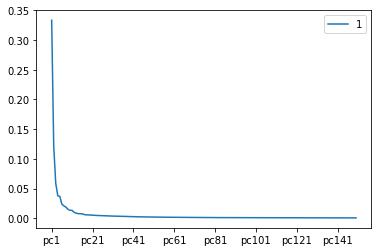

In [394]:
import matplotlib.pyplot as plt
scree = pd.DataFrame(var_imp).T[1]
scree.reset_index()
scree = scree[1:] #take the data less the header row
scree = pd.DataFrame(scree)
print('Proportion of Variance Explained "Scree Plot"')
scree.plot()

Cumulative Proportion of Variance Explained


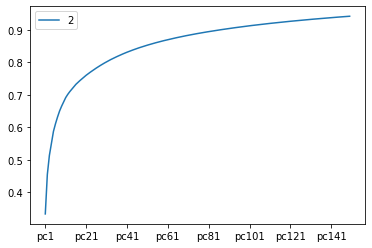

In [393]:
import matplotlib.pyplot as plt
c = pd.DataFrame(var_imp).T[2]
c.reset_index()
c = c[1:] #take the data less the header row
c = pd.DataFrame(c)
print('Cumulative Proportion of Variance Explained')
c.plot()

In [317]:
# View the eigenvectors
pca_decomp.rotation().

# See the whole table with table.as_data_frame()


Rotation: 


,,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150
0,genre.20th Century Classical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,genre.African,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,genre.Afrobeat,-0.000057,0.000188,-0.000560,-0.000459,0.000087,-0.000868,0.000337,-0.001257,0.000073,...,-0.002849,0.005760,0.000976,-0.003291,0.013182,0.004241,0.007652,-0.003330,0.000278,0.000252
3,genre.Alternative Hip-Hop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,genre.Ambient,-0.000467,-0.000572,0.000057,0.003166,-0.001542,-0.000497,0.001474,0.000746,0.001658,...,-0.002041,-0.001197,0.002005,-0.014011,-0.019637,0.024072,0.031223,-0.041442,-0.024301,0.003958
5,genre.Ambient Electronic,0.000257,0.001807,-0.000107,0.005181,-0.002587,-0.001269,-0.003552,-0.000352,-0.000747,...,0.050482,-0.016731,-0.023349,0.011987,-0.008750,-0.010225,0.014033,-0.047814,0.014296,-0.036496
6,genre.Americana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,genre.Asia-Far East,0.000506,0.000245,0.001106,-0.000151,-0.001982,-0.001152,-0.000472,-0.000281,0.000516,...,0.004580,0.000800,0.005265,0.007894,-0.012880,0.011355,-0.002461,0.004668,0.008063,0.006382
8,genre.Audio Collage,-0.000667,-0.000790,0.000173,-0.001809,0.000446,0.000457,0.002398,-0.004211,-0.000558,...,0.026973,0.008536,0.026598,-0.020073,0.005928,0.019115,-0.008419,0.042664,0.023252,0.003071
9,genre.Avant-Garde,0.003765,-0.001349,0.010681,0.002888,-0.012955,-0.006555,0.001105,-0.014239,-0.002778,...,-0.031819,0.049303,0.186953,-0.075944,0.029946,0.053097,-0.064406,0.046212,-0.014309,0.012107



See the whole table with table.as_data_frame()


In [320]:
subset_dataset_new = pca_decomp.predict(subset_dataset_train)

pca prediction progress: |████████████████████████████████████████████████| 100%


In [321]:
subset_dataset_new

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
6.65008,0.82621,6.18083,-3.37748,-0.198988,-2.53827,-3.01073,0.375106,-1.06921,-0.210277,-2.33847,-0.475394,-1.38448,-0.0618123,-1.27677,-0.450059,-1.03239,0.0222769,2.1746,-0.458321,0.359341,0.881524,0.739828,-1.23571,1.19917,-1.20478,0.606058,-0.301885,0.487399,0.755337,0.183214,-0.151962,0.800252,0.568407,0.388607,0.387908,-0.554114,0.865407,-0.312302,-0.108116,0.402964,-0.897784,0.186938,-0.401325,-0.313336,0.728262,-0.719875,0.0200486,0.201163,0.0548947,0.691182,-0.314376,-0.311619,-0.408289,-0.227976,-0.165978,0.257599,0.0804983,0.192763,-0.318534,0.0902005,-0.0430107,0.124893,1.04193,-0.181808,-0.43531,-0.184186,-0.314823,-0.099303,0.00615335,0.452915,-0.0934679,-0.243392,-0.199323,0.145374,0.576231,0.273385,-0.406955,-0.00845416,0.47343,-0.27532,0.0254955,0.530334,0.605802,0.334825,-0.154648,0.485157,0.012605,-0.354933,0.0280643,0.391166,0.0400386,-0.175125,-0.715675,0.336559,0.550717,-0.0340549,0.0697013,-0.422642,-0.489379,-0.229367,0.077442,0.435114,0.0263921,0.164672,-0.326294,0.102791,-0.0323035,-0.0718939,-0.00213796,0.020291,-0.289218,0.210584,0.11523,-0.30569,0.202348,-0.292812,0.0041838,0.374982,0.274594,0.241852,0.254972,0.352514,0.0170127,-0.131773,-0.257964,0.234232,0.186527,0.157676,0.181662,-0.218443,-0.168607,-0.380079,0.576099,0.190859,0.10829,0.221098,0.164172,0.36598,-0.227593,-0.106785,-0.38987,0.0399404,-0.0210299,0.514894,0.29191,-0.301671,-0.202229,-0.226544,0.285225
-5.07427,-3.66635,2.27148,0.0647612,0.785389,1.63406,1.84829,-0.326412,0.962084,-1.51808,-0.640584,1.08811,0.235043,-1.03202,1.25395,-0.226454,-1.36655,-0.766888,-0.807982,0.417375,-0.989162,0.0177658,0.817201,0.242844,1.13445,-0.855636,0.173069,0.154768,-0.956925,-0.407383,0.593243,-0.197853,-0.0808618,-0.162755,0.499555,-0.075802,-0.0630051,-0.369245,-0.565883,-0.9153,-0.149773,0.239301,0.0981655,0.487137,-0.0308711,0.443106,0.334774,0.563016,-0.488152,-0.000994966,-0.0647666,-0.46881,-0.80258,-0.159415,0.103943,0.137955,-0.442609,-0.150759,-0.227783,-0.232195,-0.292708,-0.756142,-0.0502602,-0.0826311,0.157095,0.162533,0.17362,-0.0165272,0.506678,-0.135863,-0.407157,-0.306931,-0.35049,-0.623008,-0.141697,0.473448,-0.392714,-0.174421,-0.166763,0.248736,-0.250836,-0.207102,0.11966,-0.257434,-0.272481,-0.4258,-0.230412,-0.7288,-0.147565,-0.131729,-0.4059,-0.451762,-0.276038,0.088021,0.287758,0.0456975,0.0869992,0.233311,-0.128501,0.328355,0.289454,-0.119231,0.0697824,-0.059596,-0.232094,-0.0193258,-0.0878831,-0.227372,0.33852,0.27102,-0.364186,0.00811275,-0.0588391,0.0537595,0.139979,-0.0893147,-0.0538404,0.310957,-0.0276866,0.111082,-0.00597875,0.269256,-0.00609839,-0.122492,-0.0318037,-0.309929,0.394691,0.125533,0.203648,0.232584,-0.135429,-0.355754,0.202241,-0.0925645,0.0330727,0.00745001,-0.244896,-0.309511,0.0789862,-0.00286865,0.376951,-0.285208,-0.139561,0.0217808,0.258571,0.0521861,-0.118294,0.0824947,-0.00628984,-0.463765
-4.48403,-2.23476,-0.0878487,-2.98023,-0.608978,2.62266,-0.275223,-1.91727,2.6942,1.46505,1.1802,-0.97435,-0.88069,-0.579352,-0.229001,0.14757,0.533419,-1.26734,-0.524178,-1.02239,0.0877022,-0.663728,0.203607,-0.199425,-0.765732,0.0217463,1.17774,-0.820569,1.81447,0.850228,-0.357122,-0.69541,-0.637283,0.380722,0.786969,0.370844,-0.5

In [322]:
#append the labels for a new dataset
subset_dataset_new = subset_dataset_new.cbind(subset_dataset_train[y])

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,genre
6.65008,0.82621,6.18083,-3.37748,-0.198988,-2.53827,-3.01073,0.375106,-1.06921,-0.210277,-2.33847,-0.475394,-1.38448,-0.0618123,-1.27677,-0.450059,-1.03239,0.0222769,2.1746,-0.458321,0.359341,0.881524,0.739828,-1.23571,1.19917,-1.20478,0.606058,-0.301885,0.487399,0.755337,0.183214,-0.151962,0.800252,0.568407,0.388607,0.387908,-0.554114,0.865407,-0.312302,-0.108116,0.402964,-0.897784,0.186938,-0.401325,-0.313336,0.728262,-0.719875,0.0200486,0.201163,0.0548947,0.691182,-0.314376,-0.311619,-0.408289,-0.227976,-0.165978,0.257599,0.0804983,0.192763,-0.318534,0.0902005,-0.0430107,0.124893,1.04193,-0.181808,-0.43531,-0.184186,-0.314823,-0.099303,0.00615335,0.452915,-0.0934679,-0.243392,-0.199323,0.145374,0.576231,0.273385,-0.406955,-0.00845416,0.47343,-0.27532,0.0254955,0.530334,0.605802,0.334825,-0.154648,0.485157,0.012605,-0.354933,0.0280643,0.391166,0.0400386,-0.175125,-0.715675,0.336559,0.550717,-0.0340549,0.0697013,-0.422642,-0.489379,-0.229367,0.077442,0.435114,0.0263921,0.164672,-0.326294,0.102791,-0.0323035,-0.0718939,-0.00213796,0.020291,-0.289218,0.210584,0.11523,-0.30569,0.202348,-0.292812,0.0041838,0.374982,0.274594,0.241852,0.254972,0.352514,0.0170127,-0.131773,-0.257964,0.234232,0.186527,0.157676,0.181662,-0.218443,-0.168607,-0.380079,0.576099,0.190859,0.10829,0.221098,0.164172,0.36598,-0.227593,-0.106785,-0.38987,0.0399404,-0.0210299,0.514894,0.29191,-0.301671,-0.202229,-0.226544,0.285225,Post-Rock
-5.07427,-3.66635,2.27148,0.0647612,0.785389,1.63406,1.84829,-0.326412,0.962084,-1.51808,-0.640584,1.08811,0.235043,-1.03202,1.25395,-0.226454,-1.36655,-0.766888,-0.807982,0.417375,-0.989162,0.0177658,0.817201,0.242844,1.13445,-0.855636,0.173069,0.154768,-0.956925,-0.407383,0.593243,-0.197853,-0.0808618,-0.162755,0.499555,-0.075802,-0.0630051,-0.369245,-0.565883,-0.9153,-0.149773,0.239301,0.0981655,0.487137,-0.0308711,0.443106,0.334774,0.563016,-0.488152,-0.000994966,-0.0647666,-0.46881,-0.80258,-0.159415,0.103943,0.137955,-0.442609,-0.150759,-0.227783,-0.232195,-0.292708,-0.756142,-0.0502602,-0.0826311,0.157095,0.162533,0.17362,-0.0165272,0.506678,-0.135863,-0.407157,-0.306931,-0.35049,-0.623008,-0.141697,0.473448,-0.392714,-0.174421,-0.166763,0.248736,-0.250836,-0.207102,0.11966,-0.257434,-0.272481,-0.4258,-0.230412,-0.7288,-0.147565,-0.131729,-0.4059,-0.451762,-0.276038,0.088021,0.287758,0.0456975,0.0869992,0.233311,-0.128501,0.328355,0.289454,-0.119231,0.0697824,-0.059596,-0.232094,-0.0193258,-0.0878831,-0.227372,0.33852,0.27102,-0.364186,0.00811275,-0.0588391,0.0537595,0.139979,-0.0893147,-0.0538404,0.310957,-0.0276866,0.111082,-0.00597875,0.269256,-0.00609839,-0.122492,-0.0318037,-0.309929,0.394691,0.125533,0.203648,0.232584,-0.135429,-0.355754,0.202241,-0.0925645,0.0330727,0.00745001,-0.244896,-0.309511,0.0789862,-0.00286865,0.376951,-0.285208,-0.139561,0.0217808,0.258571,0.0521861,-0.118294,0.0824947,-0.00628984,-0.463765,Hip-Hop
-4.48403,-2.23476,-0.0878487,-2.98023,-0.608978,2.62266,-0.275223,-1.91727,2.6942,1.46505,1.1802,-0.97435,-0.88069,-0.579352,-0.229001,0.14757,0.533419,-1.26734,-0.524178,-1.02239,0.0877022,-0.663728,0.203607,-0.199425,-0.765732,0.0217463,1.17774,-0.820569,1.81447,0.850228,-0.357122,-0.69541,-0.637283,0.38072

In [325]:
train,test,valid = subset_dataset_new.split_frame(ratios=[0.7, 0.15], seed=123)

#reset column names now thats they are new
x = subset_dataset_new.col_names

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for x base models (limited to 1 hour max runtime by default) max_runtime_secs = 3600
aml = H2OAutoML(max_models=5, balance_classes = True, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |███████
14:39:34.271: DRF_1_AutoML_20200521_143824 [DRF def_1] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
14:39:35.274: GBM_1_AutoML_20200521_143824 [GBM def_1] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
14:39:36.279: GBM_2_AutoML_20200521_143824 [GBM def_2] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?

█
14:39:37.284: GBM_3_AutoML_20200521_143824 [GBM def_3] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
14:39:38.287: GBM_4_AutoML_20200521_143824 [GBM def_4] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
14:39:39.293: GBM_5_AutoML_20200521_143824 [GBM def_5] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?

███
14:39:40.305: DeepLearning_1_AutoML_20200521_143824 [DeepLearning def_1] failed: java.lang.IllegalArgumentException: Error during sa

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_20200521_143824,0.460576,3.40226,0.909342,0.826902
XGBoost_1_AutoML_20200521_143824,0.464909,3.36971,0.906687,0.822082
XGBoost_2_AutoML_20200521_143824,0.475285,3.53385,0.921331,0.848852
XGBoost_grid__1_AutoML_20200521_143824_model_1,0.481105,3.69067,0.941491,0.886406
GLM_1_AutoML_20200521_143824,0.48227,3.46551,0.946056,0.895023
StackedEnsemble_BestOfFamily_AutoML_20200521_143824,0.48227,3.47438,0.944981,0.892989
StackedEnsemble_AllModels_AutoML_20200521_143824,0.48227,3.47424,0.944706,0.89247


In [326]:
# Get leaderboard with `extra_columns` = 'ALL'
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms
XGBoost_3_AutoML_20200521_143824,0.460576,3.40226,0.909342,0.826902,4976,0.264677
XGBoost_1_AutoML_20200521_143824,0.464909,3.36971,0.906687,0.822082,5445,0.227026
XGBoost_2_AutoML_20200521_143824,0.475285,3.53385,0.921331,0.848852,4091,0.219207
XGBoost_grid__1_AutoML_20200521_143824_model_1,0.481105,3.69067,0.941491,0.886406,3821,0.160239
GLM_1_AutoML_20200521_143824,0.48227,3.46551,0.946056,0.895023,43,0.158543
StackedEnsemble_BestOfFamily_AutoML_20200521_143824,0.48227,3.47438,0.944981,0.892989,10841,0.378665
StackedEnsemble_AllModels_AutoML_20200521_143824,0.48227,3.47424,0.944706,0.89247,73248,2.21144


In [329]:
pred = aml.predict(test)
pred.head()

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,20th Century Classical,African,Afrobeat,Alternative Hip-Hop,Ambient,Ambient Electronic,Americana,Asia-Far East,Audio Collage,Avant-Garde,Balkan,Banter,Big Band/Swing,Black-Metal,Bluegrass,Blues,Brazilian,Breakbeat,Breakcore - Hard,British Folk,Celtic,Chamber Music,Chill-out,Chip Music,Chiptune,Choral Music,Christmas,Classical,Comedy,Compilation,Composed Music,Contemporary Classical,Country,Country & Western,Dance,Death-Metal,Disco,Downtempo,Drone,Drum & Bass,Dubstep,Easy Listening,Electro-Punk,Electroacoustic,Electronic,Europe,Experimental,Experimental Pop,Field Recordings,Folk,Freak-Folk,Free-Folk,Free-Jazz,French,Funk,Garage,Glitch,Goth,Grindcore,Hardcore,Hip-Hop,Hip-Hop Beats,Holiday,House,IDM,Improv,Indian,Indie-Rock,Industrial,Instrumental,International,Interview,Jazz,Jazz: Out,Jazz: Vocal,Jungle,Kid-Friendly,Klezmer,Krautrock,Latin,Latin America,Lo-Fi,Loud-Rock,Lounge,Metal,Middle East,Minimal Electronic,Minimalism,Modern Jazz,Musique Concrete,Nerdcore,New Age,New Wave,No Wave,Noise,Noise-Rock,North African,Novelty,Nu-Jazz,Old-Time / Historic,Poetry,Polka,Pop,Post-Punk,Post-Rock,Power-Pop,Progressive,Psych-Folk,Psych-Rock,Punk,Radio,Radio Art,Rap,Reggae - Dub,Rock,Rock Opera,Rockabilly,Romany (Gypsy),Salsa,Shoegaze,Singer-Songwriter,Sludge,Soul-RnB,Sound Art,Sound Collage,Sound Effects,Sound Poetry,Soundtrack,Space-Rock,Spoken,Spoken Weird,Spoken Word,Surf,Synth Pop,Talk Radio,Tango,Techno,Thrash,Trip-Hop,Turkish,Unclassifiable
Punk,0.000838973,0.000840218,0.00433419,0.000841511,0.0129755,0.0171135,0.000839188,0.00442452,0.0180751,0.00614907,0.000839945,0.000839692,0.000844397,0.000838697,0.00335298,0.00884563,0.000839914,0.000840751,0.000842591,0.000840205,0.000844673,0.000840519,0.000841102,0.0142236,0.00900461,0.00366528,0.000845846,0.00174667,0.000841065,0.000843456,0.000841919,0.000846161,0.00684479,0.000846366,0.00385037,0.000843485,0.0074165,0.000842791,0.0118705,0.00084069,0.00084436,0.00493527,0.00454072,0.000844257,0.00936573,0.000838549,0.00803239,0.00228333,0.00367919,0.0308292,0.00911147,0.00409589,0.000841901,0.00398466,0.0042173,0.00453035,0.00444214,0.000844897,0.000838793,0.00357016,0.0377655,0.00433347,0.000841022,0.00442996,0.00407503,0.0145731,0.00083974,0.00084027,0.00426263,0.000841061,0.0163592,0.00702824,0.0388192,0.000846839,0.000838711,0.000841518,0.000845829,0.000835465,0.000841196,0.000840167,0.000843968,0.0104982,0.0126415,0.000840577,0.00867924,0.000844586,0.000843052,0.00883146,0.000843224,0.000844524,0.000843864,0.000847569,0.00398675,0.000838673,0.027688,0.00465705,0.000843051,0.00426554,0.000842892,0.0154147,0.000841024,0.000841833,0.0065588,0.021506,0.0106892,0.00491517,0.0082138,0.0127018,0.0234697,0.277406,0.000844534,0.00501218,0.00365484,0.0147912,0.039763,0.000842548,0.000838114,0.000841835,0.000846638,0.00272667,0.0134544,0.000847959,0.000841948,0.000844672,0.00457858,0.00336548,0.000845512,0.00161681,0.00380264,0.00419764,0.00889346,0.000841195,0.000839022,0.000839553,0.000841709,0.000842263,0.000838436,0.000839486,0.00823573,0.000842581,0.000841725
Electronic,0.000866934,0.00086822,0.00447864,0.000869556,0.0227654,0.0141171,0.000867155,0.00457198,0.0215959,0.00529249,0.000867938,0.000867677,0.000872538,0.000866648,0.00346473,0.00914044,0.000867907,0.000868771,0.000870672,0.000868206,0.000872823,0.000868532,0.000869133,0.0136673,0.00930471,0.00378743,0.000874035,0.0596767,0.000869095,0.000871566,0.000869978,0.000874361,0.0162726,0.000874573,0.00397869,0.000871596,0.00766367,0.000870878,0.0122661,0.000868707,0.0008725,0.00509975,0.00469205,0.000872393,0.134664,0.000866495,0.02296,0.00773032,0.0154046,0.0440268,0.00941513,0.00423239,0.000869959,0.00411746,0.00435785,0.012878,0.00459018,0.000873055,0.000866748,0.00368914,0.00194157,0.0044779,0.000869051,0.00457759,0.00421084,0.01751,0.000867726,0.000868274,0.00440469,0.000869091,0.00744322,0.00726247,0.0604524,0.000875062,0.000866663,0.000869564,0.000874018,0.000863309,0.00086923,0.000868167,0.000872095,0.0328032,0.0130628,0

In [328]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.7806021781462241
RMSE: 0.8835169371020706
LogLoss: 3.2123235546086875
Mean Per-Class Error: 0.22029941875966516

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,20th Century Classical,African,Afrobeat,Alternative Hip-Hop,Ambient,Ambient Electronic,Americana,Asia-Far East,Audio Collage,Avant-Garde,...,Synth Pop,Talk Radio,Tango,Techno,Thrash,Trip-Hop,Turkish,Unclassifiable,Error,Rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,2 / 2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,1 / 1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375,3 / 8



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.369565
1,2,0.445652
2,3,0.500000
3,4,0.554348
4,5,0.554348
5,6,0.586956
6,7,0.586956
7,8,0.597826
8,9,0.619565
9,10,0.630435


In [171]:
h2o.cluster().shutdown()

H2O session _sid_a6e1 was not closed properly.
